# Dataset : classic4.csv
# Embeddings : GloVe



Ne disposant que d'une connexion Internet limitée nous n'avons pas travaillé avec la version de GloVe à 300 dimensions (glove.840B.300d) mais avec celle à 100 dimensions (glove.6B.100d)

# Chargement des données et paramétrage de l'environnement

## Installations

In [ ]:
!pip install umap-learn
!pip install scikit-learn-extra
!pip install soyclustering
!pip install rpy2==3.5.1

## Import des librairies

In [ ]:
import os
import math
from tqdm import tqdm

# Data Science
import numpy as np
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader
from scipy.sparse import csr_matrix
import tensorflow.compat.v1 as tf

# Graphiques
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models import KeyedVectors

# Réduction de dimension
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from soyclustering import SphericalKMeans

# Métriques
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score

# R
%load_ext rpy2.ipython
import rpy2.robjects as robjects

In [ ]:
%%R

install.packages('NbClust')
install.packages('clustrd')
install.packages('aricode')

library(NbClust)
library(clustrd)
library(aricode)

## Fonctions

In [ ]:
def data_preprocessing(text):
  '''
  Fonction permettant de nettoyer et préparer le texte
  pour les word embeddings
  '''
  text = re.sub(re.compile('<.*?>'), '', text) # supprimer les tags html
  text =  re.sub('[^A-Za-z0-9]+', ' ', text) # conserver les lettres et les chiffres
  text = text.lower() # mettre en miniscules
  tokens = nltk.word_tokenize(text) # tokenization
  text = [word for word in tokens if word not in stopwords.words('english')] # supprimer les stop words
  text = [WordNetLemmatizer().lemmatize(word) for word in text] # lemmatization
  text = ' '.join(text) # jointure des mots

  return text


def embed_glove(text_vec, model):
  '''
  Fonction permettant de créer les embeddings GloVe
  '''
  placeholder_vec = np.zeros(model.vector_size)
  placeholder_vec_ = np.zeros(model.vector_size)
  vec_count = 0

  for text in text_vec:
    try:
      placeholder_vec = placeholder_vec + model.get_vector(text)
      vec_count += 1
    except:
      continue
  
  if vec_count == 0:
    return placeholder_vec
  
  return placeholder_vec / vec_count


def clust_viz_2D(result, pred_labels):
  '''
  Fonction permettant de créer des graphiques 2D
  pour comparer les clusters prédits avec les vrais clusters
  '''
  # Dimensions
  dim1 = result[:, 0]
  dim2 = result[:, 1]

  # Création des graphiques des clusters sur 2 dimensions
  pred_colors = [dict_colors[i] for i in pred_labels]
  plt.figure(figsize = (7, 5))

  # Affichage des clusters prédits
  plt.subplot(1, 2, 1)
  plt.title("Clusters prédits")
  plt.scatter(x=dim1, y=dim2, c=pred_colors, alpha=0.2)

  # Affichage des vrais clusters
  plt.subplot(1, 2, 2)
  plt.title("Vrais clusters")
  plt.scatter(x=dim1, y=dim2, c=y_colors, alpha=0.2)
  plt.show()

def clust_viz_3D(result, pred_labels, elev1=10, azim1=45, elev2=10, azim2=45):
  '''
  Fonction permettant de créer des graphiques 2D
  pour comparer les clusters prédits avec les vrais clusters
  '''
  # Dimensions
  dim1 = result[:, 0]
  dim2 = result[:, 1]
  dim3 = result[:, 2]

  # Affichage des clusters prédits en 3D
  pred_colors = [dict_colors[i] for i in pred_labels]
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(dim1, dim2, dim3, 
            marker='o', s=30, facecolor=pred_colors, alpha=0.2)
  ax.set_xlabel('Dim1')
  ax.set_ylabel('Dim2')
  ax.set_zlabel('Dim3')
  ax.view_init(elev=elev1, azim=azim1)
  plt.title('Clusters prédits')

  # Affichage des vrais clusters en 3D
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.scatter(dim1, dim2, dim3, 
            marker='o', s=30, facecolor=y_colors, alpha=0.2)
  ax.set_xlabel('Dim1')
  ax.set_ylabel('Dim2')
  ax.set_zlabel('Dim3')
  ax.view_init(elev=elev2, azim=azim2)
  plt.title('Vrais clusters')
  plt.draw()


def print_metrics(y_pred, y):
  '''
  Fonction permettant d'afficher les métriques 
  NMI, Accuracy et ARI
  '''
  print("NMI score: ", normalized_mutual_info_score(y_pred, y))
  print("Accuracy: ", accuracy_score(y_pred, y))
  print("ARI: ", adjusted_rand_score(y_pred, y))


class AutoEncoder(torch.nn.Module):
  def __init__(self, input_dim, embedding_dim):
    super().__init__()
    self.input_dim = input_dim
    self.embedding_dim = embedding_dim
    # Encoder : linear layer + ReLU activation function
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(self.input_dim, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, self.embedding_dim))
    # Decoder : linear layer + ReLU activation function   
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(self.embedding_dim, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, self.input_dim),
        torch.nn.Sigmoid()) # outputs between 0 and 1

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
        
    return decoded

def autoencoder(X, 
                embedding_dim, 
                n_epochs=50, 
                batch_size=64, 
                learning_rate=1e-3, 
                weight_decay=1e-8, 
                seed=None, 
                return_model=False):
  # Utiliser le GPU si disponible
  if torch.cuda.is_available():
    device = 'cuda'
  else:
    device = 'cpu'
  # Seed
  if seed is not None:
    torch.manual_seed(seed)
  # Load
  dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)
  # Instanciate model
  model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

  if device == 'cuda':
    model.cuda()
  # Loss function
  loss_function = torch.nn.MSELoss()
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

  losses = []
  # Training
  model.train()
  for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
      batch = batch.to(device)
      reconstructed = model(batch)
        
      loss = loss_function(reconstructed, batch)
        
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      losses.append(loss)
  # Evaluating
  model.eval()
  model.to("cpu")
  encoded_X = model.encoder(torch.tensor(X))
  encoded_X = encoded_X.detach().numpy()

  if return_model:
    return encoded_X, model, losses
  else:
    return encoded_X

In [ ]:
# Deep K-means (DKM)
"""
Credits:
This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, 
                                units=dimension, 
                                activation=activation, 
                                name=name, 
                                reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data


class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
    The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

## Chargement des données et preprocessing

In [ ]:
# Chargement du csv
df = pd.read_csv('/content/classic4.csv', index_col=0)
df.head()

text label
0  Computer-Aided Analysis and Design of Informat...  cacm
1  Milestones in Cataloging In the case of the pr...  cisi
2  childhood psychosis. a description is given of...   med
3  neonatal hepatitis or familial neonatal obstru...   med
4  Handbook of Comparative Librarianship The firs...  cisi

In [ ]:
# Affichage du nombre de documents par groupe
df.groupby('label').count()

text
label      
cacm   3204
cisi   1460
cran   1398
med    1033

In [ ]:
# Nettoyage et préparation du texte pour les embeddings
df['text_clean'] = df['text'].apply(lambda x: data_preprocessing(x))

# Transformation du texte nettoyé en liste de tokens pour les embeddings
df['text_vec'] = [nltk.word_tokenize(text) for text in df['text_clean']]
df.head()

text label  \
0  Computer-Aided Analysis and Design of Informat...  cacm   
1  Milestones in Cataloging In the case of the pr...  cisi   
2  childhood psychosis. a description is given of...   med   
3  neonatal hepatitis or familial neonatal obstru...   med   
4  Handbook of Comparative Librarianship The firs...  cisi   

                                          text_clean  \
0  computer aided analysis design information sys...   
1  milestone cataloging case present study dr leh...   
2  childhood psychosis description given diagnost...   
3  neonatal hepatitis familial neonatal obstructi...   
4  handbook comparative librarianship first part ...   

                                            text_vec  
0  [computer, aided, analysis, design, informatio...  
1  [milestone, cataloging, case, present, study, ...  
2  [childhood, psychosis, description, given, dia...  
3  [neonatal, hepatitis, familial, neonatal, obst...  
4  [handbook, comparative, librarianship, first, ...

In [ ]:
# Séparation des documents et des clusters
X = df['text_vec']
y = df['label']

# Encodage des catégories en entier
y = LabelEncoder().fit_transform(y)

# GloVe

Ne disposant que d'une connexion Internet limitée nous n'avons pas travaillé avec la version de GloVe à 300 dimensions (glove.840B.300d) mais avec celle à 100 dimensions (glove.6B.100d)

In [ ]:
# Chargement des embeddings GloVe
glove_file = '/content/glove.6B.100d.txt'

# Création du modèle GloVe (transformation des embeddings GloVe au format word2vec)
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
glove_model.save_word2vec_format('glove_model')
print(glove_model)

KeyedVectors<vector_size=100, 400000 keys>


In [ ]:
# Création des embeddings GloVe
X_glove = X.apply(lambda x: embed_glove(x, glove_model))

# Transformation en array (vecteur de dimension 100)
array_glove = np.array(X_glove.to_list())
array_glove.shape

(7095, 100)

# Partie 1 : Approche Tandem

## Clustering sur l'espace d'origine

In [ ]:
# Paramétrage des couleurs des classes pour les graphiques
dict_colors = {0: 'b', 1: 'g',  2: 'r', 3: 'y' } 
y_colors = [dict_colors[i] for i in y]

NMI score:  0.507973495652681
Accuracy:  0.4944326990838619
ARI:  0.37965400449143505


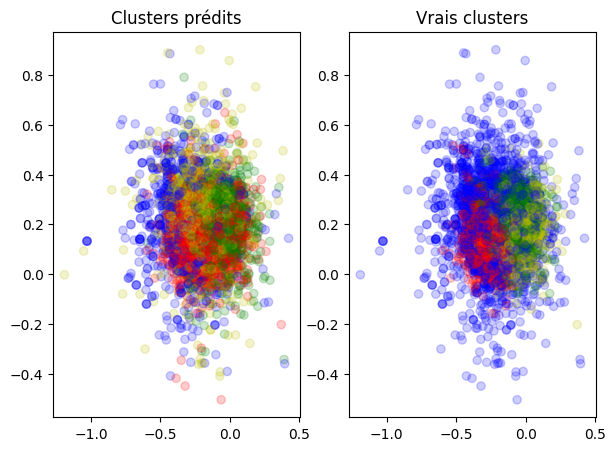

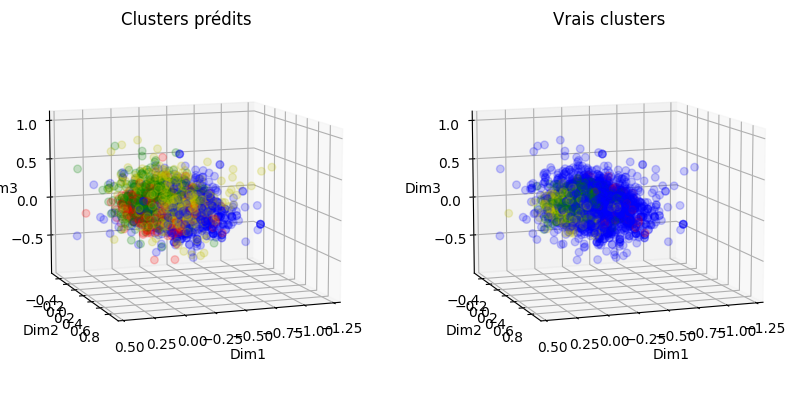

In [ ]:
# KMeans++
kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=7)
kmeans.fit(array_glove)

# Evaluation de la qualité du clustering
print_metrics(kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, kmeans.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, kmeans.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

NMI score:  0.3041486956005585
Accuracy:  0.493446088794926
ARI:  0.2196865863346589


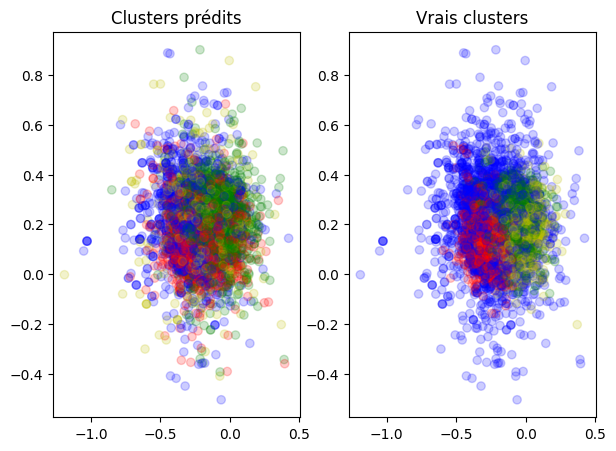

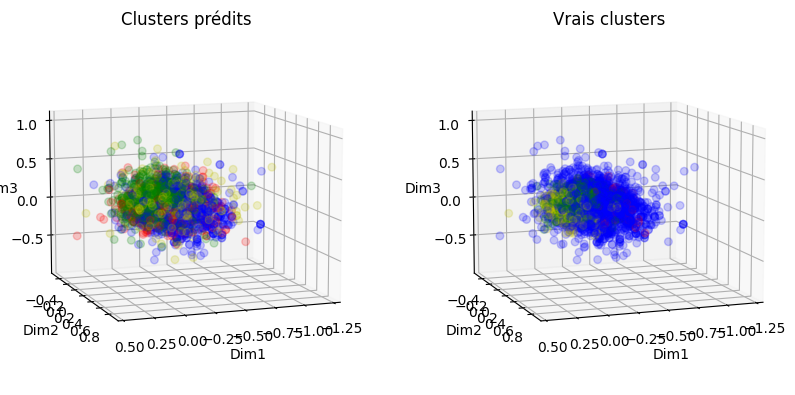

In [ ]:
# KMedoids 
kmedoids = KMedoids(n_clusters=4, random_state=7)
kmedoids.fit(array_glove)

# Evaluation de la qualité du clustering
print_metrics(kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, kmedoids.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, kmedoids.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

NMI score:  0.32538254944776257
Accuracy:  0.1113460183227625
ARI:  0.16245798618771798


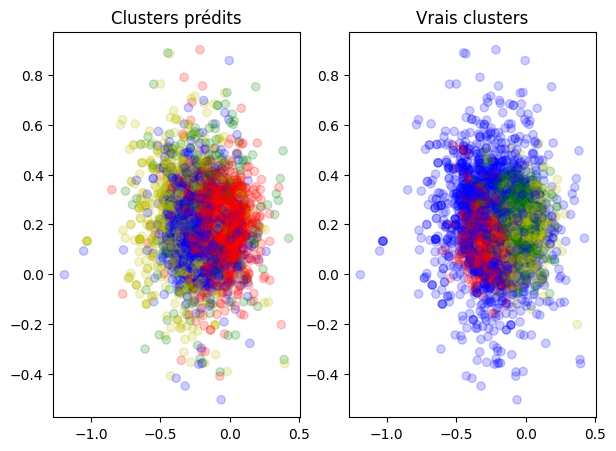

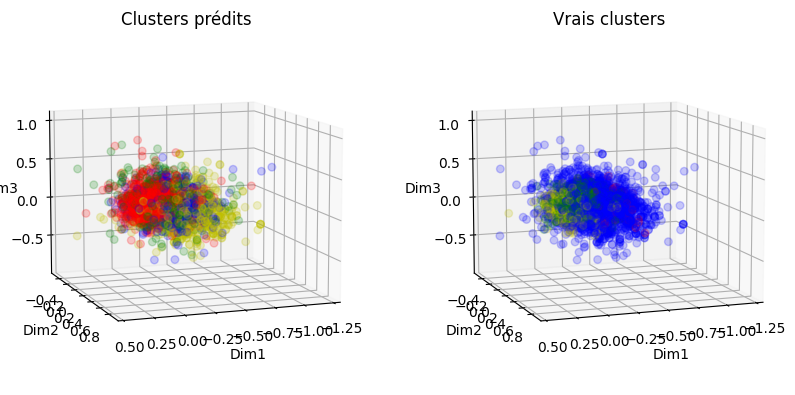

In [ ]:
# Spherical KMeans
skmeans = SphericalKMeans(n_clusters=4, random_state=7)
skmeans.fit(csr_matrix(array_glove))

# Evaluation de la qualité du clustering
print_metrics(skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, skmeans.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, skmeans.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

NMI score:  0.0005216849523584687
Accuracy:  0.4511627906976744
ARI:  -0.00035415950080903996


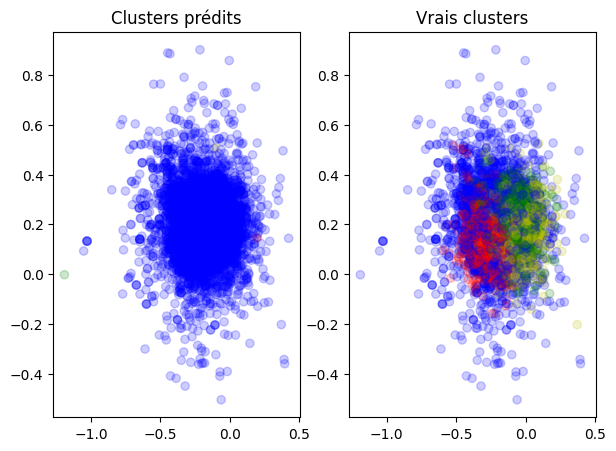

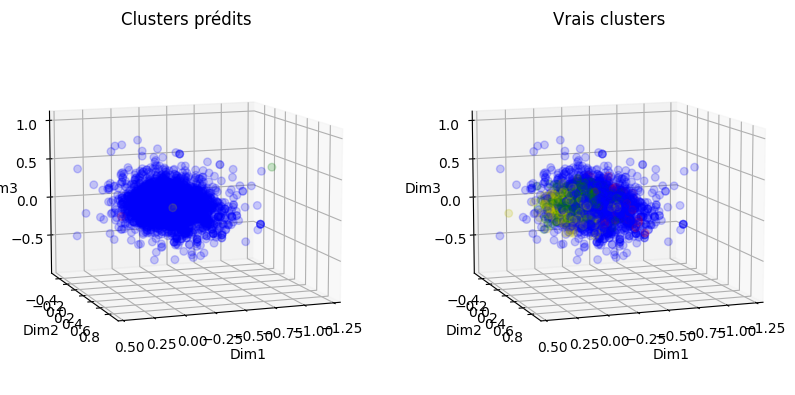

In [ ]:
# HAC/CAH avec lien simple
hac_single = AgglomerativeClustering(n_clusters=4, linkage='single') 
hac_single.fit(array_glove)

# Evaluation de la qualité du clustering
print_metrics(hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, hac_single.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, hac_single.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

NMI score:  0.00878460260706115
Accuracy:  0.44425651867512334
ARI:  -0.00602896204438047


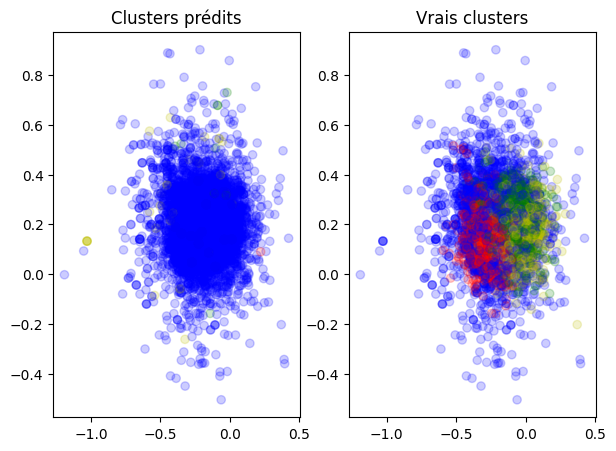

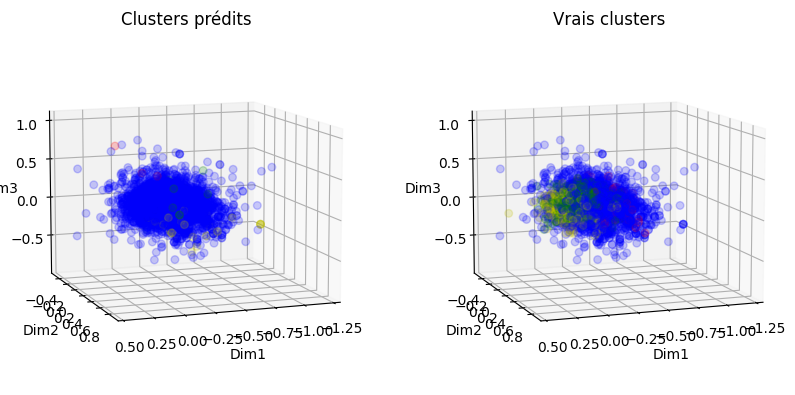

In [ ]:
# HAC/CAH avec lien complet
hac_complete = AgglomerativeClustering(n_clusters=4, linkage='complete') 
hac_complete.fit(array_glove)

# Evaluation de la qualité du clustering
print_metrics(hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, hac_complete.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, hac_complete.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

NMI score:  0.0015578731951478664
Accuracy:  0.4503171247357294
ARI:  -0.0010603789636248401


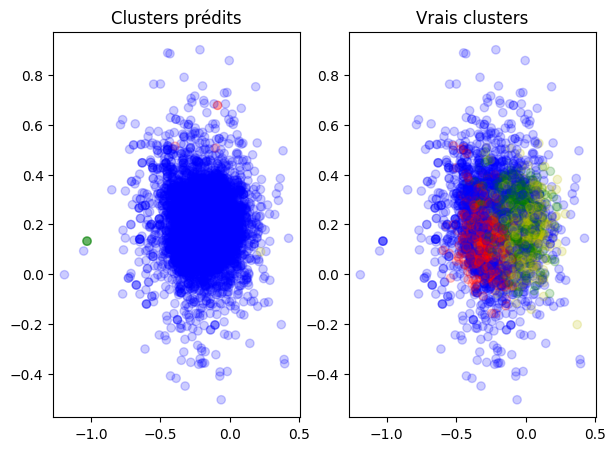

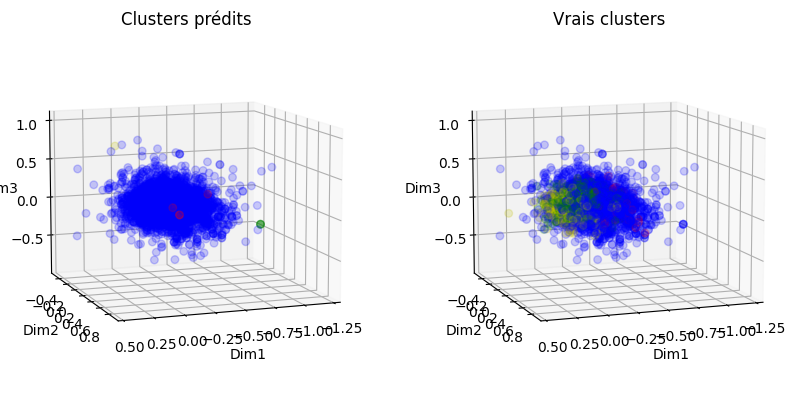

In [ ]:
# HAC/CAH avec lien moyen
hac_avg = AgglomerativeClustering(n_clusters=4, linkage='average') 
hac_avg.fit(array_glove)

# Evaluation de la qualité du clustering
print_metrics(hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, hac_avg.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, hac_avg.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

NMI score:  0.5619375079931063
Accuracy:  0.009020436927413672
ARI:  0.43041940095462533


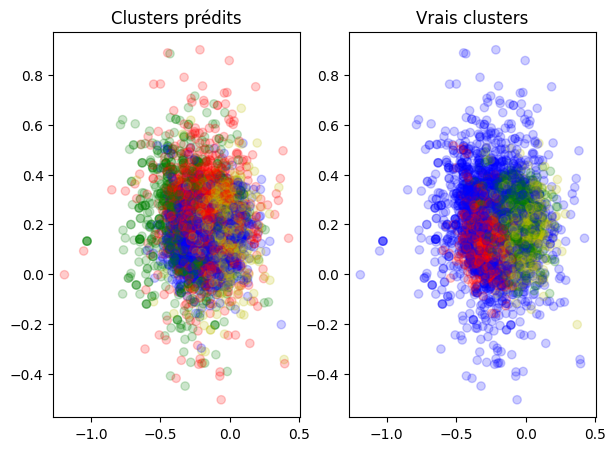

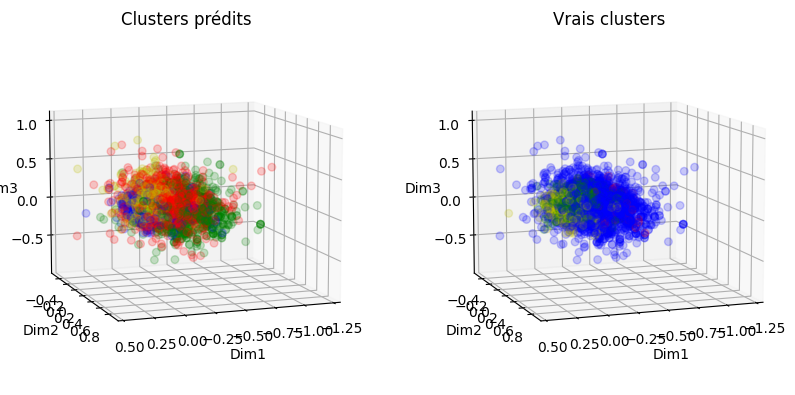

In [ ]:
# HAC/CAH avec lien de Ward
hac_ward = AgglomerativeClustering(n_clusters=4, linkage='ward') 
hac_ward.fit(array_glove)

# Evaluation de la qualité du clustering
print_metrics(hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_glove, hac_ward.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_glove, hac_ward.labels_, elev1=10, azim1=70, elev2=10, azim2=70)

Dans l'espace d'origine les données forment un amas et sont difficilement regroupables. La classe 0 (bleu) semble envelopper les autres ce qui complique le clustering.

## Clustering après réduction de dimension

### PCA

PC1     26.559660
PC2     10.656384
PC3      6.090062
PC4      5.156082
PC5      3.540254
PC6      2.911647
PC7      2.258856
PC8      2.140104
PC9      1.874951
PC10     1.733654
dtype: float64


<Axes: xlabel='Principal components', ylabel='Explained variance'>

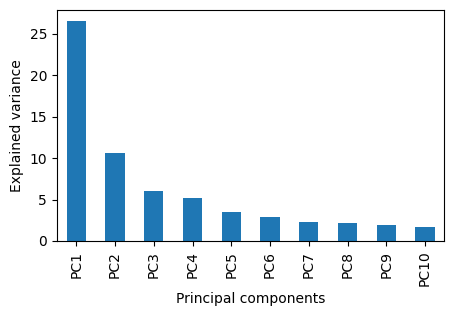

In [ ]:
# Réduction de dimension avec PCA
pca = PCA(random_state=7)
pca_result = pca.fit_transform(array_glove)

# Conversion des résultats en dataframe
pca_columns = ['PC' + str(c) for c in range(1, pca_result.shape[1]+1, 1)]
df_pca = pd.DataFrame(pca_result, index=X_glove.index, columns=pca_columns) 

# Affichage  du pourcentage de variance expliquée par les 10 premières composantes principales
explained_variance = pd.Series(dict(zip(df_pca.columns, 100.0*pca.explained_variance_ratio_)))
print(explained_variance[0:10])
explained_variance[0:10].plot(kind='bar', figsize=(5, 3), rot=90, ylabel='Explained variance', xlabel='Principal components')

Les deux premières composantes expliquent 36% de la variance. La troisième n'explique que 6% de plus. C'est beaucoup moins qu'avec les embeddings Word2Vec. Les résultats risquent d'être moins bons. La méthode du coude recommande de poursuivre seulement avec les deux premières composantes.



<Axes: xlabel='PC1', ylabel='PC2'>

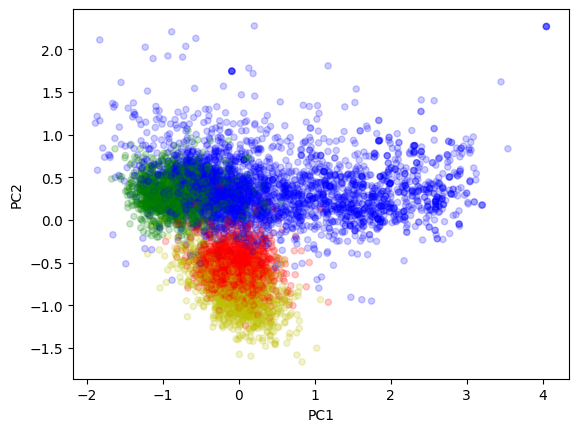

In [ ]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2, random_state=7)
pca_result = pca.fit_transform(array_glove)

# Conversion des résultats en dataframe
pca_columns = ['PC' + str(c) for c in range(1, pca_result.shape[1]+1, 1)]
df_pca = pd.DataFrame(pca_result, index=X_glove.index, columns=pca_columns) 

# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_pca.plot(x='PC1', y='PC2', kind='scatter', color=y_colors, alpha=0.2)

On constate que les classes sont plus faciles à distinguer dans ce sous-espace.

NMI score:  0.49322442764307645
Accuracy:  0.19985905567300916
ARI:  0.32544443644206233


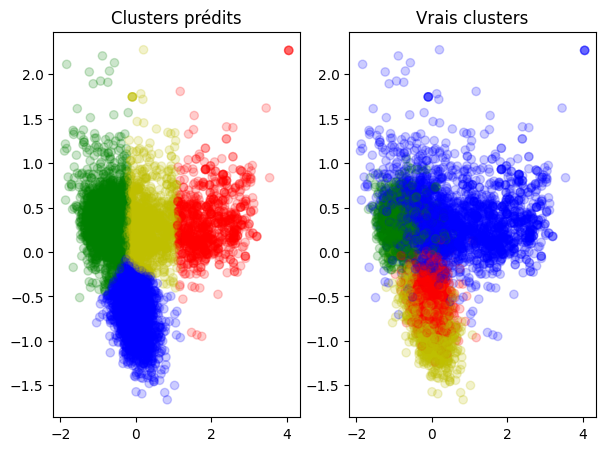

In [ ]:
# KMeans++
pca_kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=7)
pca_kmeans.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_kmeans.labels_)

NMI score:  0.4963605354809854
Accuracy:  0.010993657505285413
ARI:  0.34654374615879063


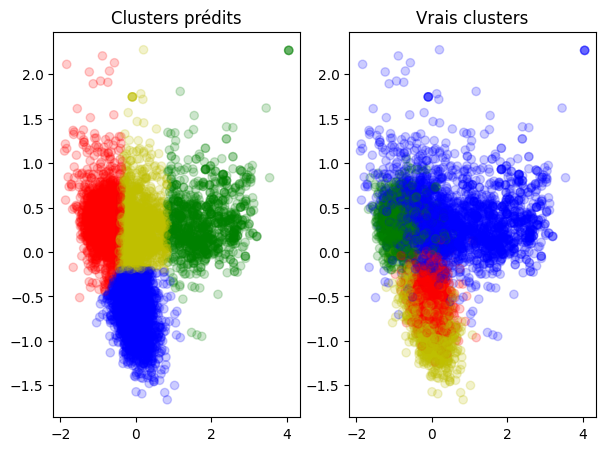

In [ ]:
# KMedoids 
pca_kmedoids = KMedoids(n_clusters=4, random_state=7)
pca_kmedoids.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_kmedoids.labels_)

NMI score:  0.48766289729371276
Accuracy:  0.10190274841437633
ARI:  0.33380923069471147


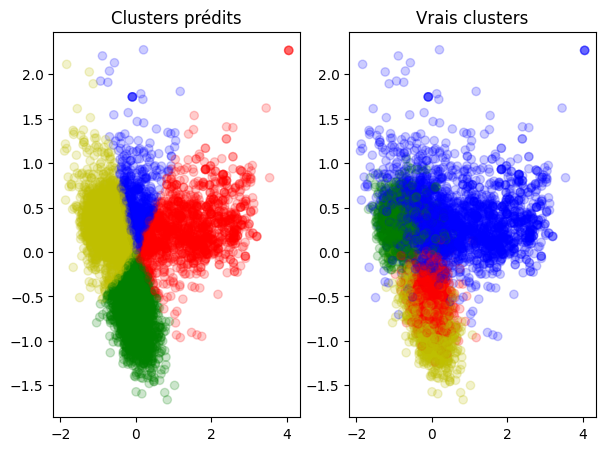

In [ ]:
# Spherical KMeans
pca_skmeans = SphericalKMeans(n_clusters=4, random_state=7)
pca_skmeans.fit(csr_matrix(pca_result))

# Evaluation de la qualité du clustering
print_metrics(pca_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_skmeans.labels_)

NMI score:  0.0010409695135070005
Accuracy:  0.4507399577167019
ARI:  -0.0007074604616245472


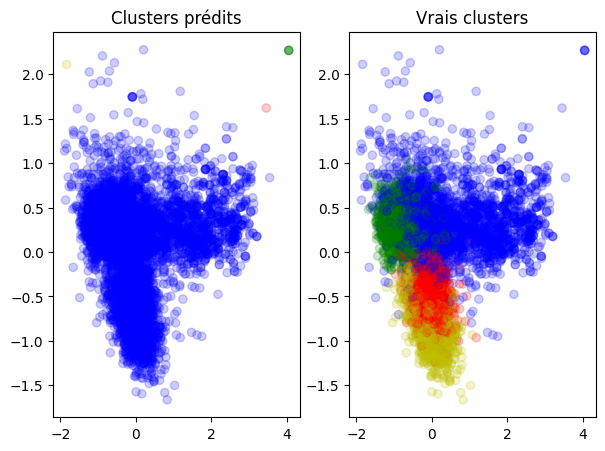

In [ ]:
# HAC/CAH avec lien simple
pca_hac_single = AgglomerativeClustering(n_clusters=4, linkage='single') 
pca_hac_single.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_single.labels_)

NMI score:  0.23043223481926764
Accuracy:  0.32389006342494714
ARI:  0.09168694745545777


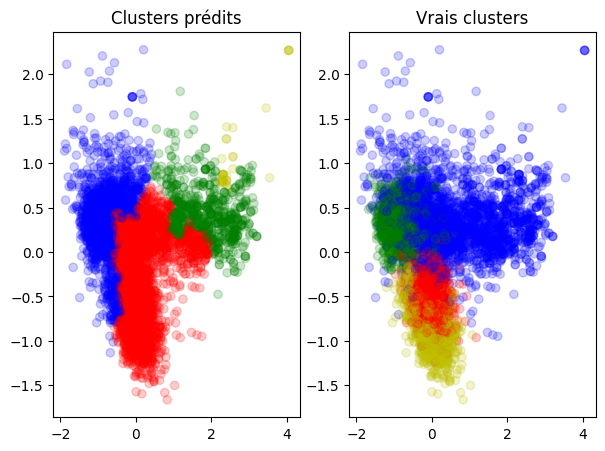

In [ ]:
# HAC/CAH avec lien complet
pca_hac_complete = AgglomerativeClustering(n_clusters=4, linkage='complete') 
pca_hac_complete.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_complete.labels_)

NMI score:  0.16969197860097324
Accuracy:  0.21141649048625794
ARI:  -0.036179211409626676


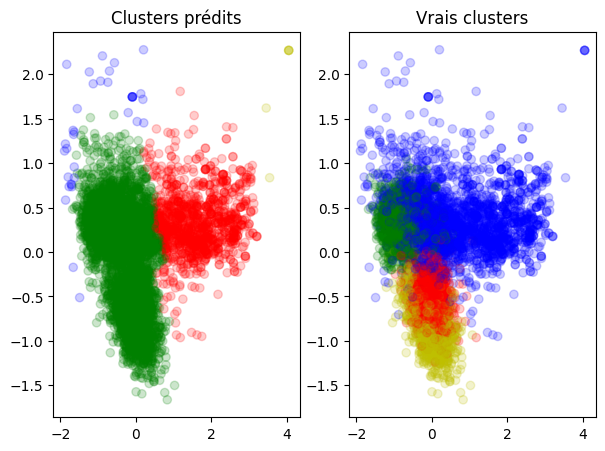

In [ ]:
# HAC/CAH avec lien moyen
pca_hac_avg = AgglomerativeClustering(n_clusters=4, linkage='average') 
pca_hac_avg.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_avg.labels_)

NMI score:  0.4900143952024533
Accuracy:  0.4321353065539112
ARI:  0.3117478488169696


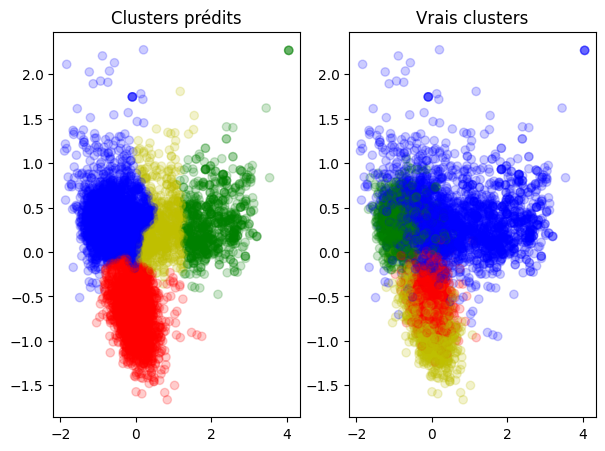

In [ ]:
# HAC/CAH avec lien de Ward
pca_hac_ward = AgglomerativeClustering(n_clusters=4, linkage='ward') 
pca_hac_ward.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_ward.labels_)

Les scores ne sont pas forcément meilleurs que ceux obtenus dans l'espace d'origine. Une séparation non-linéaire sera peut être plus appropriée.

### t-SNE

In [ ]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=7)
tsne_result = tsne.fit_transform(array_glove)

# Conversion des résultats en dataframe
tsne_columns = ['Dim' + str(c) for c in range(1, tsne_result.shape[1]+1, 1)]
df_tsne = pd.DataFrame(tsne_result, index=X_glove.index, columns=tsne_columns) 

<Axes: xlabel='Dim1', ylabel='Dim2'>

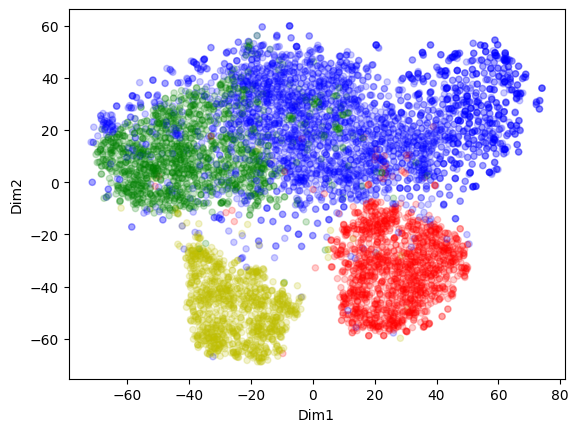

In [ ]:
# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_tsne.plot(x='Dim1', y='Dim2', kind='scatter', color=y_colors, alpha=0.2)

Globalement les classes sont moins denses et un peu mieux séparées qu'après l'ACP. La réduction de dimension non-linéaire de t-SNE semble donner des résultats un peu meilleurs.

NMI score:  0.5137568663435652
Accuracy:  0.18252290345313602
ARI:  0.40026214180086195


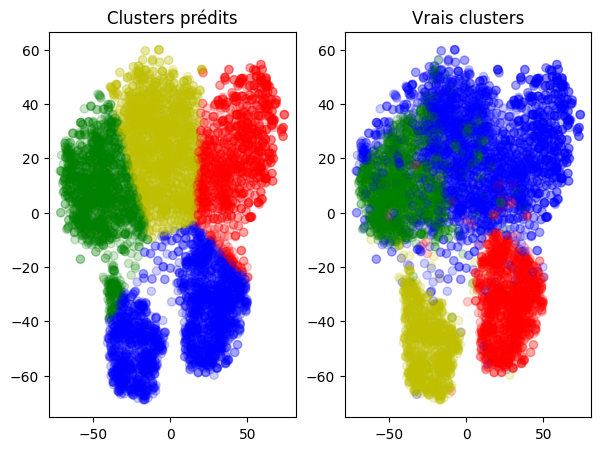

In [ ]:
# KMeans++
tsne_kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=7)
tsne_kmeans.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_kmeans.labels_)

NMI score:  0.6731891165921451
Accuracy:  0.20902043692741368
ARI:  0.546552028538004


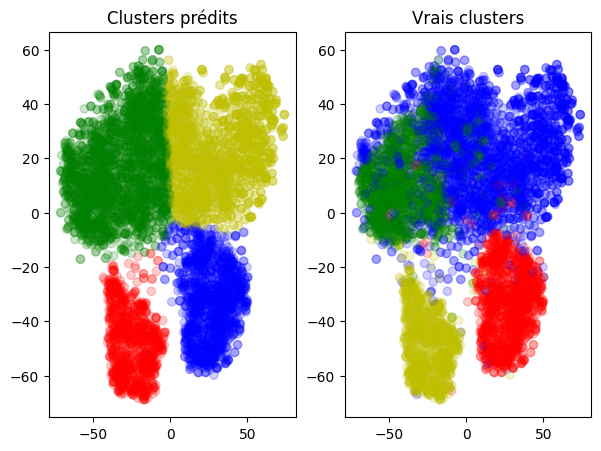

In [ ]:
# KMedoids 
tsne_kmedoids = KMedoids(n_clusters=4, random_state=7)
tsne_kmedoids.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_kmedoids.labels_)

NMI score:  0.6388369257540157
Accuracy:  0.025933756166314305
ARI:  0.5291294647647156


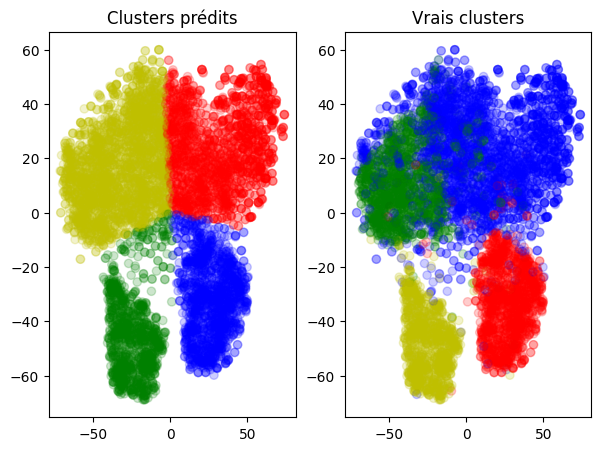

In [ ]:
# Spherical KMeans
tsne_skmeans = SphericalKMeans(n_clusters=4, random_state=7)
tsne_skmeans.fit(csr_matrix(tsne_result))

# Evaluation de la qualité du clustering
print_metrics(tsne_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_skmeans.labels_)

NMI score:  0.0041147739851848915
Accuracy:  0.44820295983086683
ARI:  -0.0028124220933926206


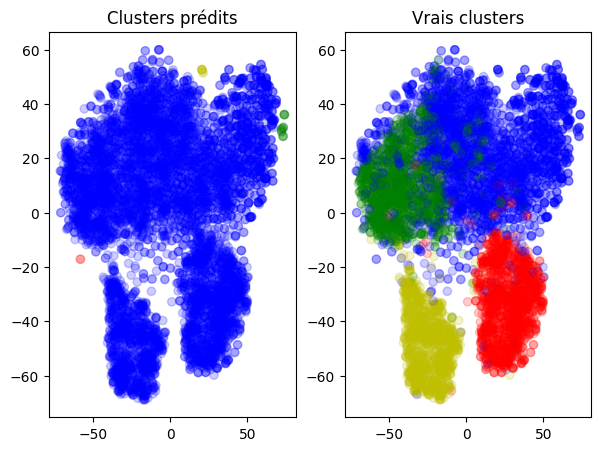

In [ ]:
# HAC/CAH avec lien simple
tsne_hac_single = AgglomerativeClustering(n_clusters=4, linkage='single') 
tsne_hac_single.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_single.labels_)

NMI score:  0.4743069360337079
Accuracy:  0.17744890768146582
ARI:  0.34816860263242544


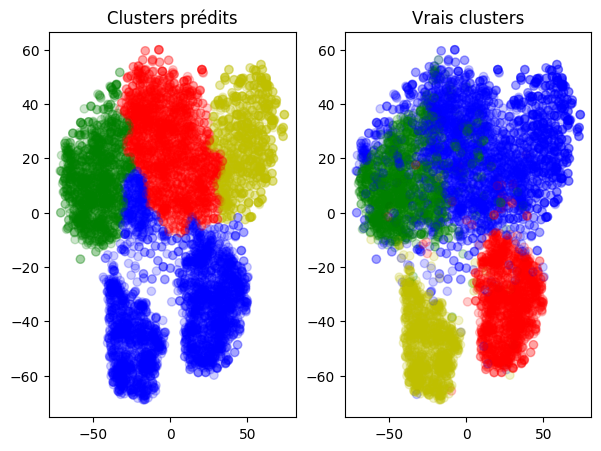

In [ ]:
# HAC/CAH avec lien complet
tsne_hac_complete = AgglomerativeClustering(n_clusters=4, linkage='complete') 
tsne_hac_complete.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_complete.labels_)

NMI score:  0.6863420282748466
Accuracy:  0.37899929527836507
ARI:  0.49840210175397026


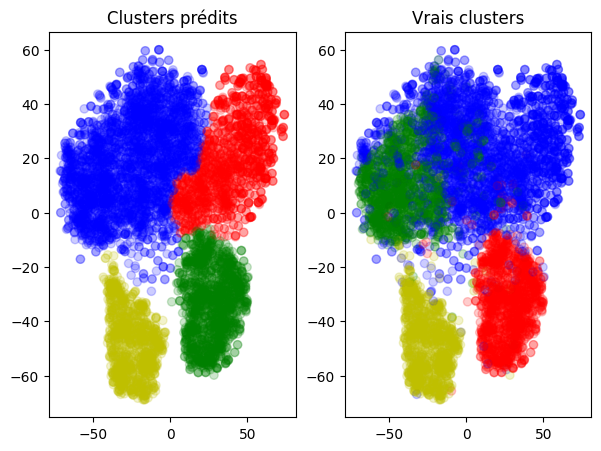

In [ ]:
# HAC/CAH avec lien moyen
tsne_hac_avg = AgglomerativeClustering(n_clusters=4, linkage='average') 
tsne_hac_avg.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_avg.labels_)

NMI score:  0.4900143952024533
Accuracy:  0.4321353065539112
ARI:  0.3117478488169696


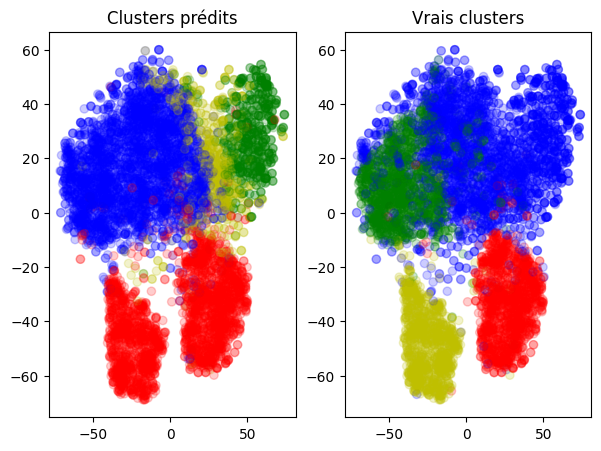

In [ ]:
# HAC/CAH avec lien de Ward
tsne_hac_ward = AgglomerativeClustering(n_clusters=4, linkage='ward') 
tsne_hac_ward.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_ward.labels_)

Les méthodes trouvent effectivement de meilleurs clusters qu'après l'ACP.

### UMAP

In [ ]:
# Réduction de dimension avec UMAP
umap = UMAP(n_components=2, random_state=7)
umap_result = umap.fit_transform(array_glove)

# Conversion des résultats en dataframe
umap_columns = ['Dim' + str(c) for c in range(1, umap_result.shape[1]+1, 1)]
df_umap = pd.DataFrame(umap_result, index=X_glove.index, columns=umap_columns)

<Axes: xlabel='Dim1', ylabel='Dim2'>

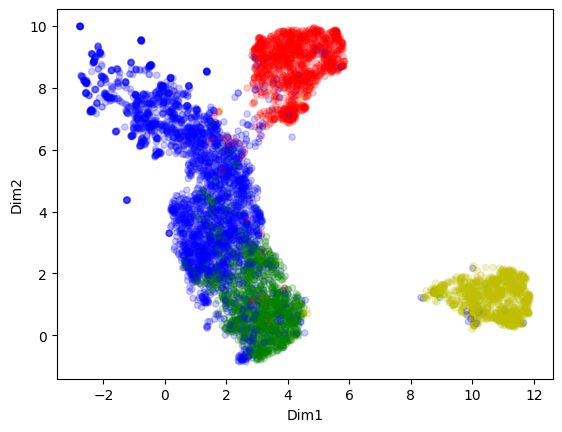

In [ ]:
# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_umap.plot(x='Dim1', y='Dim2', kind='scatter', color=y_colors, alpha=0.2)

Le groupe 3 (jaune) est bien séparée. Le groupe 2 (rouge) se distingue également. Les deux autres groupes sont imbriqués. Ces résultats sont les meilleurs obtenus jusqu'à présent.

NMI score:  0.688746081015295
Accuracy:  0.20577871740662437
ARI:  0.524756349639339


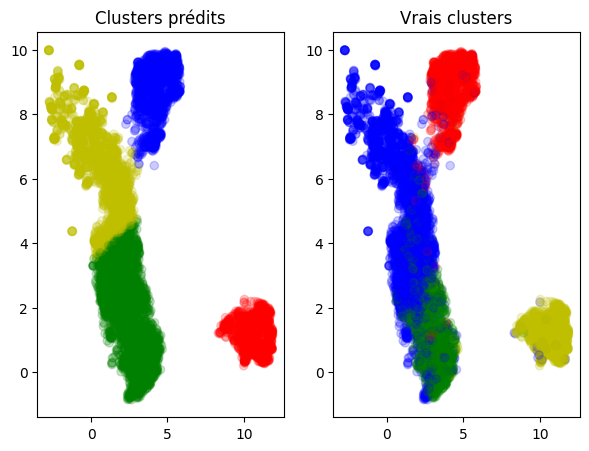

In [ ]:
# KMeans++
umap_kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=7)
umap_kmeans.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_kmeans.labels_)

NMI score:  0.6919126932526527
Accuracy:  0.25961945031712474
ARI:  0.5342560194268579


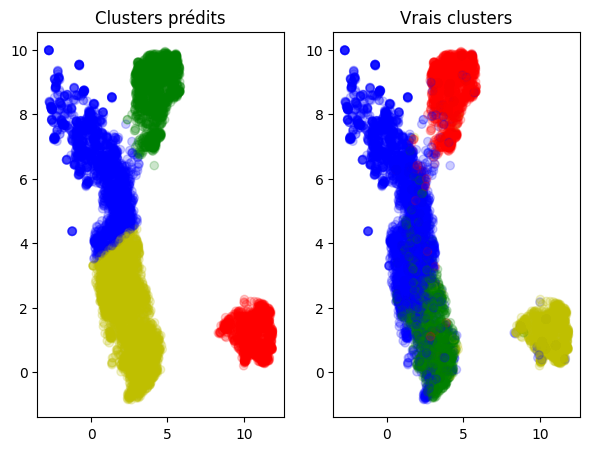

In [ ]:
# KMedoids 
umap_kmedoids = KMedoids(n_clusters=4, random_state=7)
umap_kmedoids.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_kmedoids.labels_)

NMI score:  0.43223429531548185
Accuracy:  0.33699788583509516
ARI:  0.27397525791341903


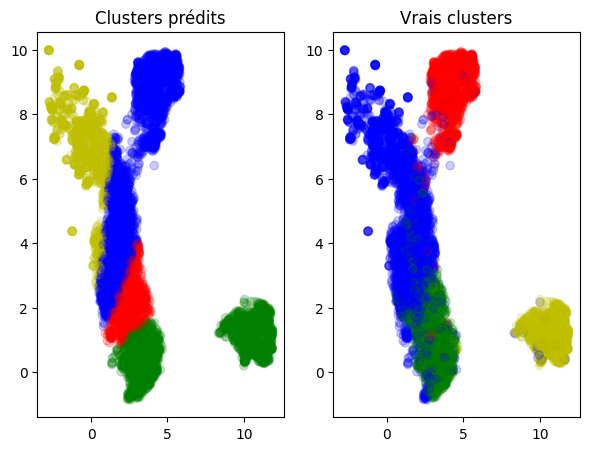

In [ ]:
# Spherical KMeans
umap_skmeans = SphericalKMeans(n_clusters=4, random_state=7)
umap_skmeans.fit(csr_matrix(umap_result))

# Evaluation de la qualité du clustering
print_metrics(umap_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_skmeans.labels_)

NMI score:  0.4450775880344946
Accuracy:  0.44778012684989427
ARI:  0.2410688706837443


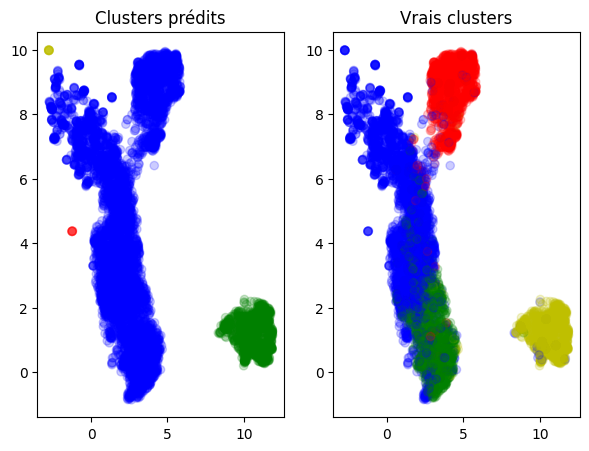

In [ ]:
# HAC/CAH avec lien simple
umap_hac_single = AgglomerativeClustering(n_clusters=4, linkage='single') 
umap_hac_single.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_single.labels_)

NMI score:  0.6862534689114611
Accuracy:  0.42832980972515855
ARI:  0.5051558332706905


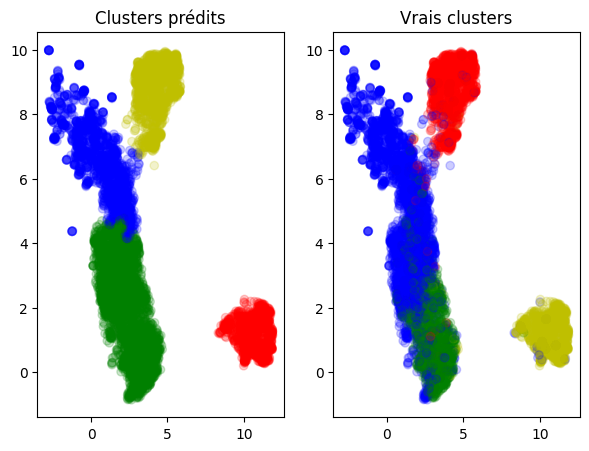

In [ ]:
# HAC/CAH avec lien complet
umap_hac_complete = AgglomerativeClustering(n_clusters=4, linkage='complete') 
umap_hac_complete.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_complete.labels_)

NMI score:  0.6747888962803986
Accuracy:  0.4700493305144468
ARI:  0.4797618937783989


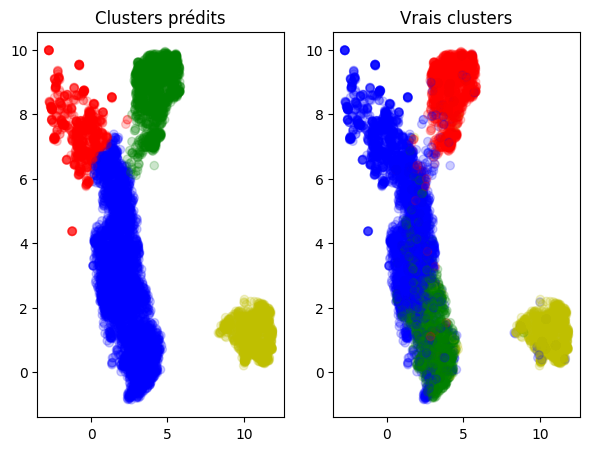

In [ ]:
# HAC/CAH avec lien moyen
umap_hac_avg = AgglomerativeClustering(n_clusters=4, linkage='average') 
umap_hac_avg.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_avg.labels_)

NMI score:  0.6765612609133228
Accuracy:  0.4448202959830867
ARI:  0.4743144105404494


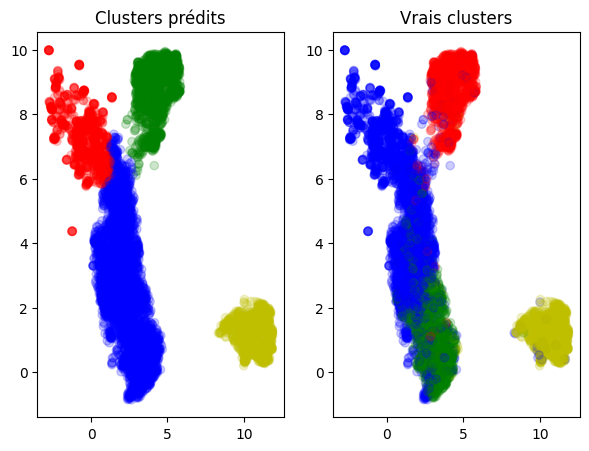

In [ ]:
# HAC/CAH avec lien de Ward
umap_hac_ward = AgglomerativeClustering(n_clusters=4, linkage='ward') 
umap_hac_ward.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_ward.labels_)

Les clusters se rapprochent de la réalité et sont et bien meilleurs que dans l'espace d'origine.

### Autoencoders

In [ ]:
# Réduction de dimension avec Autoencoders
ae_result = autoencoder(array_glove.astype("float32"), embedding_dim=2, seed=7)

# Conversion des résultats en dataframe
ae_columns = ['Dim' + str(c) for c in range(1, ae_result.shape[1]+1, 1)]
df_ae = pd.DataFrame(ae_result, index=X_glove.index, columns=ae_columns)

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


<Axes: xlabel='Dim1', ylabel='Dim2'>

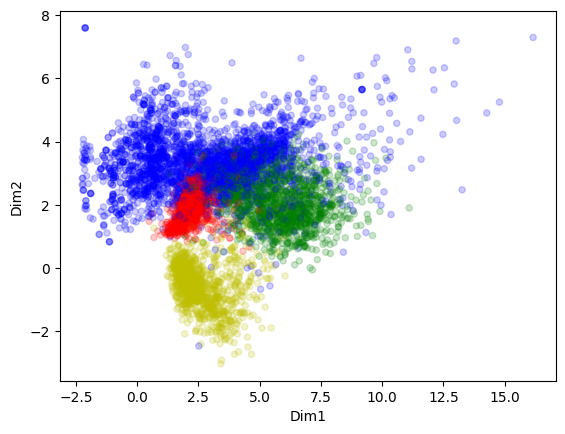

In [ ]:
# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_ae.plot(x='Dim1', y='Dim2', kind='scatter', color=y_colors, alpha=0.2)

Le groupe 3 (jaune) se distingue mais les autres sont plutôt concentrés. Les Autoencoders ne semblent pas faire mieux.

NMI score:  0.44758119304610566
Accuracy:  0.09668780831571529
ARI:  0.32031566827885466


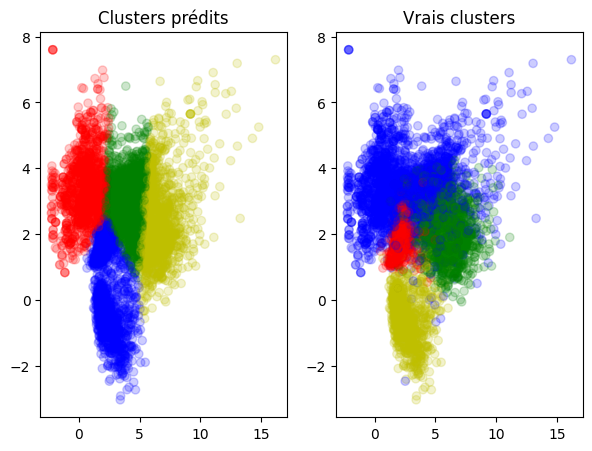

In [ ]:
# KMeans++
ae_kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=7)
ae_kmeans.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_kmeans.labels_)

NMI score:  0.5015731479435735
Accuracy:  0.654122621564482
ARI:  0.34390704114105536


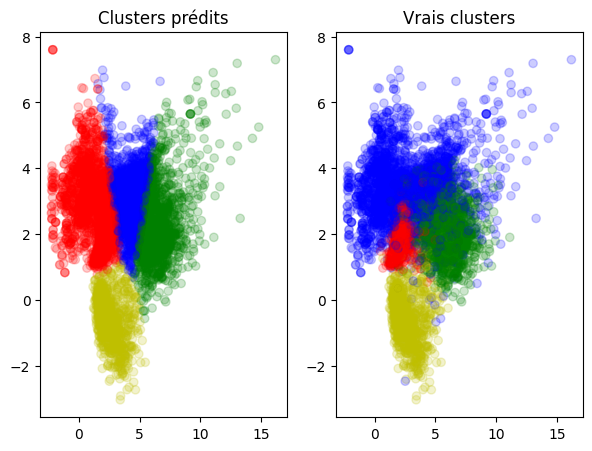

In [ ]:
# KMedoids 
ae_kmedoids = KMedoids(n_clusters=4, random_state=7)
ae_kmedoids.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_kmedoids.labels_)

NMI score:  0.4241852381049479
Accuracy:  0.2408738548273432
ARI:  0.2674962979514523


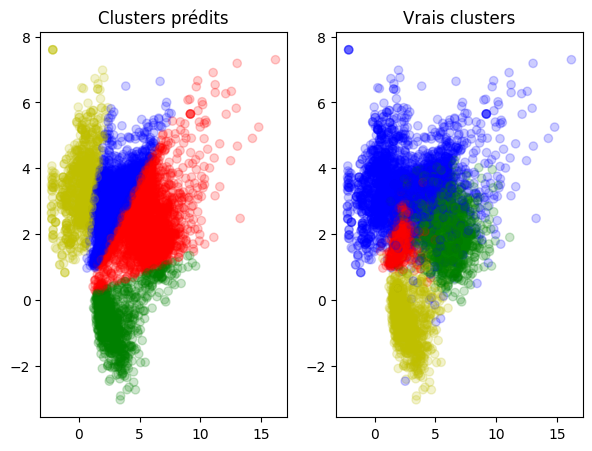

In [ ]:
# Spherical KMeans
ae_skmeans = SphericalKMeans(n_clusters=4, random_state=7)
ae_skmeans.fit(csr_matrix(ae_result))

# Evaluation de la qualité du clustering
print_metrics(ae_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_skmeans.labels_)

NMI score:  0.0010409695135070005
Accuracy:  0.4507399577167019
ARI:  -0.0007074604616245472


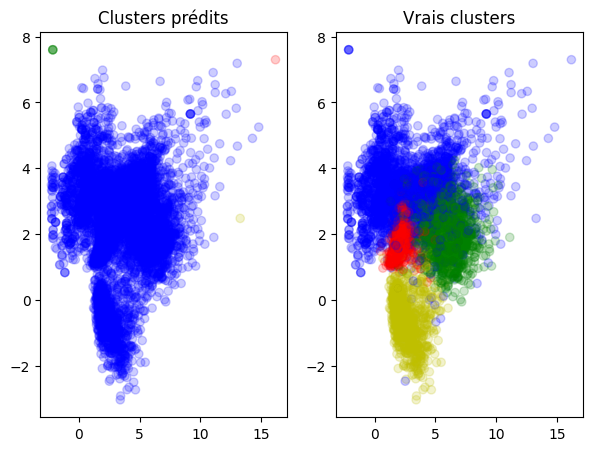

In [ ]:
# HAC/CAH avec lien simple
ae_hac_single = AgglomerativeClustering(n_clusters=4, linkage='single') 
ae_hac_single.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_single.labels_)

NMI score:  0.30923648684060395
Accuracy:  0.4355179704016913
ARI:  0.18086221142534278


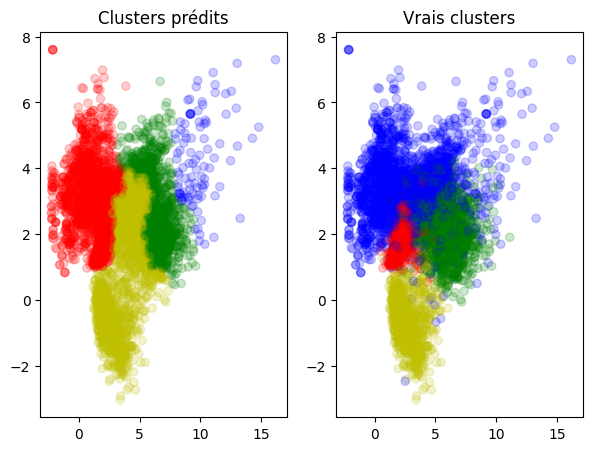

In [ ]:
# HAC/CAH avec lien complet
ae_hac_complete = AgglomerativeClustering(n_clusters=4, linkage='complete') 
ae_hac_complete.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_complete.labels_)

NMI score:  0.009862766774265373
Accuracy:  0.4417195207892882
ARI:  -0.007687619258962426


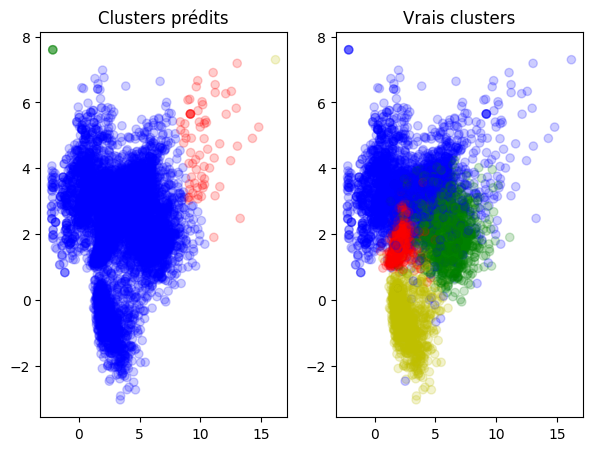

In [ ]:
# HAC/CAH avec lien moyen
ae_hac_avg = AgglomerativeClustering(n_clusters=4, linkage='average') 
ae_hac_avg.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_avg.labels_)

NMI score:  0.481086488015549
Accuracy:  0.3315010570824524
ARI:  0.32164364462766554


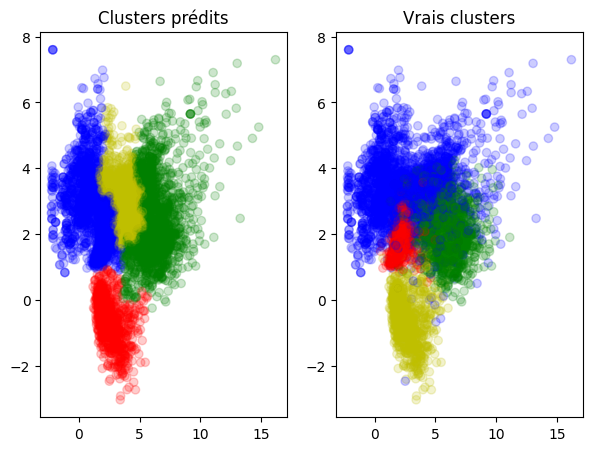

In [ ]:
# HAC/CAH avec lien de Ward
ae_hac_ward = AgglomerativeClustering(n_clusters=4, linkage='ward') 
ae_hac_ward.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_ward.labels_)

L'espace réduit créé par les Autoencoders n'améliore pas le clustering. Il n'est pas adapté car les performances sont équivalentes ou en dessous de celles obtenues dans l'espace d'origine.

## Estimation du nombre de classes avec NbClust

Estimation du nombre de classes avec le package R NbClust (avec un critère de distance euclidienne car nous comparons des lignes) 

Lien minimum (single): trouve clusters de formes allongées ou irrégulières mais sensible à l’effet de chaîne.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 8 proposed 2 as the best number of clusters 
* 4 proposed 3 as the best number of clusters 
* 7 proposed 4 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 1 proposed 8 as the best number 

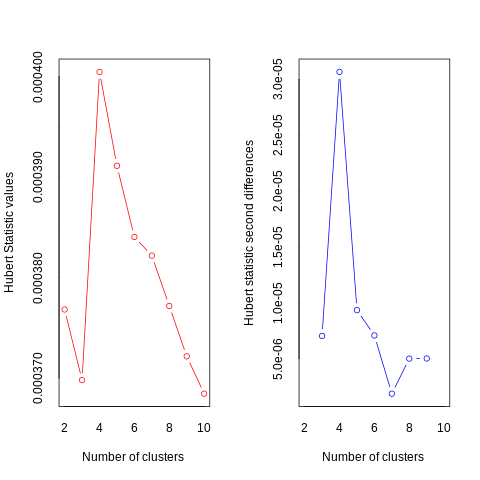

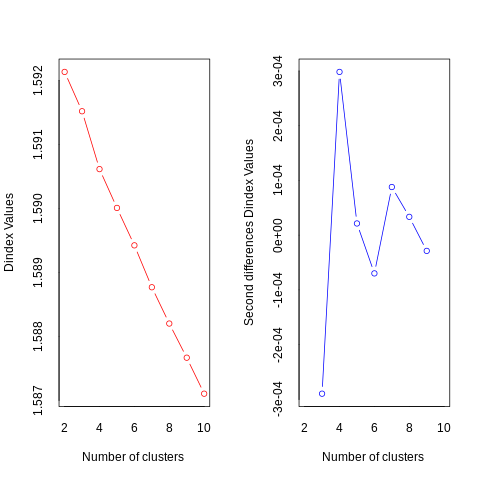

In [ ]:
%%R -i array_glove
res <- NbClust(array_glove, distance="euclidean", min.nc=2, max.nc=10,
               method="single", index="all")

Lien maximum (complete): fusionne les deux groupes qui ont la plus petite distance maximale entre leurs points.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 4 proposed 2 as the best number of clusters 
* 1 proposed 3 as the best number of clusters 
* 3 proposed 4 as the best number of clusters 
* 13 proposed 5 as the best number of clusters 
* 2 proposed 10 as the best numbe

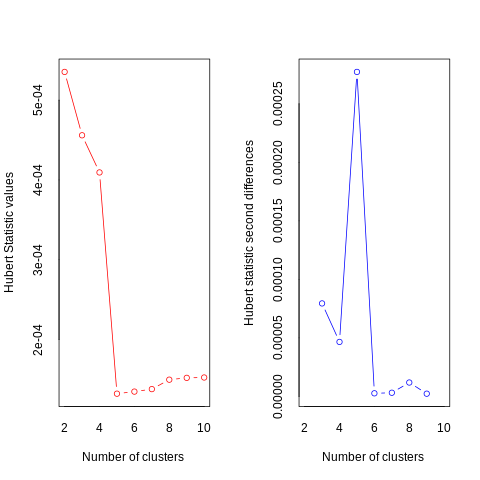

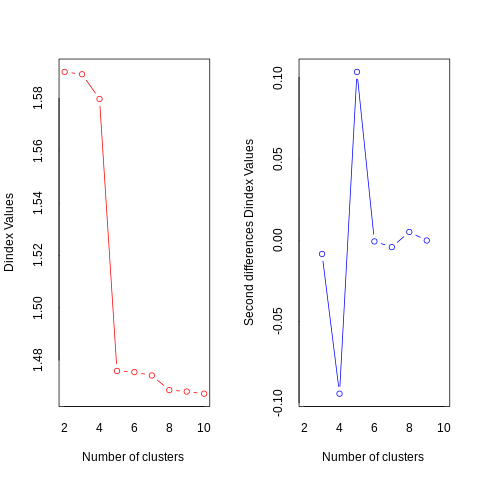

In [ ]:
%%R
res <- NbClust(array_glove, distance = "euclidean", min.nc=2, max.nc=10,
             method = "complete", index = "all")

Lien moyen (average): fusionne les deux groupes qui ont la plus petite distance moyenne entre tous leurs points.

[1] "Frey index : No clustering structure in this data set"
*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 9 proposed 2 as the best number of clusters 
* 7 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 1 proposed 6 as the

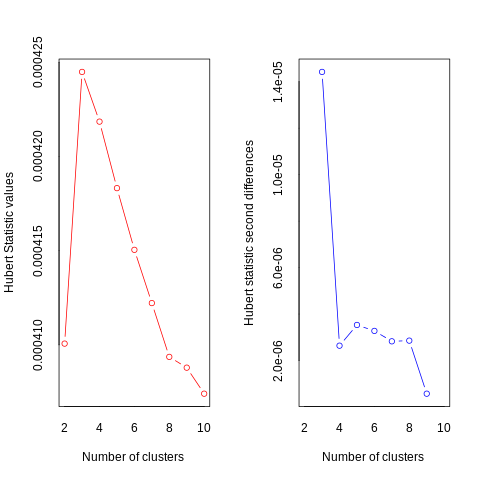

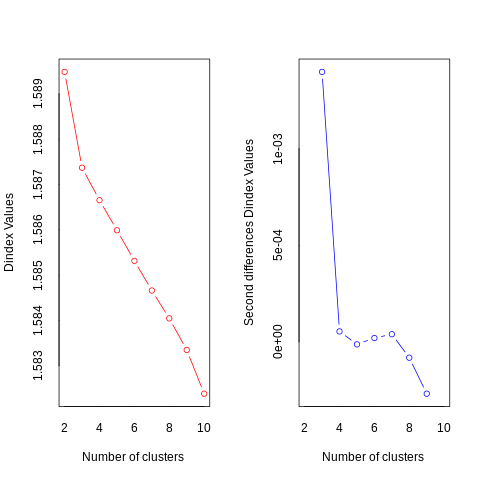

In [ ]:
%%R
res <- NbClust(array_glove, distance = "euclidean", min.nc=2, max.nc=10,
             method = "average", index = "all")

Lien de Ward: choisit les deux groupes à fusionner de manière à ce que la variance au sein de tous les groupes augmente le moins possible. Cela permet souvent d'obtenir des groupes de taille relativement égale. Trouve des clusters de forme sphérique.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 8 proposed 2 as the best number of clusters 
* 9 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 2 proposed 6 as the best number of clusters 
* 1 proposed 10 as the best number

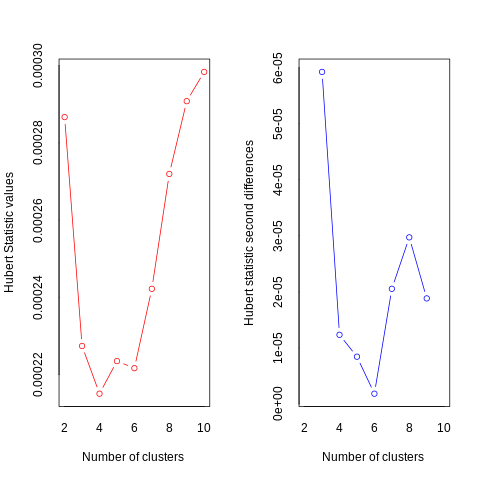

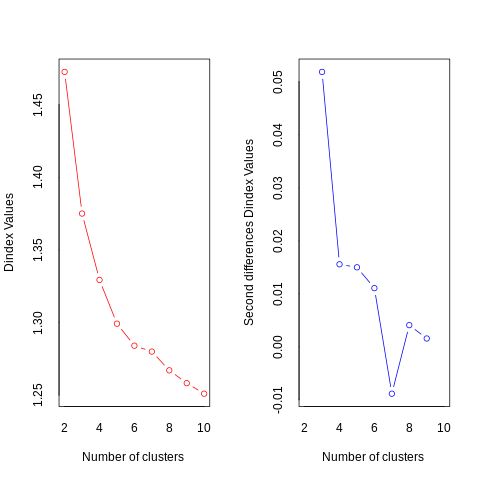

In [ ]:
%%R
res <- NbClust(array_glove, distance = "euclidean", min.nc=2, max.nc=10,
             method = "ward.D", index = "all")

Le nombre de clusters trouvé majoritairement par les différents critères est de 2. Mais le lien complet trouve 5 clusters et le lien de Ward en trouve 4.

## Synthèse

In [ ]:
# Récupération des résultats des clusterings
preds = [kmeans.labels_, 
         kmedoids.labels_,
         skmeans.labels_,
         hac_single.labels_,
         hac_complete.labels_,
         hac_avg.labels_,
         hac_ward.labels_,
         pca_kmeans.labels_,
         pca_kmedoids.labels_,
         pca_skmeans.labels_,
         pca_hac_single.labels_,
         pca_hac_complete.labels_,
         pca_hac_avg.labels_,
         pca_hac_ward.labels_,
         tsne_kmeans.labels_,
         tsne_kmedoids.labels_,
         tsne_skmeans.labels_,
         tsne_hac_single.labels_,
         tsne_hac_complete.labels_,
         tsne_hac_avg.labels_,
         tsne_hac_ward.labels_,
         umap_kmeans.labels_,
         umap_kmedoids.labels_,
         umap_skmeans.labels_,
         umap_hac_single.labels_,
         umap_hac_complete.labels_,
         umap_hac_avg.labels_,
         umap_hac_ward.labels_,
         ae_kmeans.labels_,
         ae_kmedoids.labels_,
         ae_skmeans.labels_,
         ae_hac_single.labels_,
         ae_hac_complete.labels_,
         ae_hac_avg.labels_,
         ae_hac_ward.labels_]

# Récupération des scores
nmi_scores = [normalized_mutual_info_score(y_pred, y) for y_pred in preds]
accuracy_scores = [accuracy_score(y_pred, y) for y_pred in preds]
ari_scores = [adjusted_rand_score(y_pred, y) for y_pred in preds]

# Nom des méthodes
methods = ["Kmeans++", 
           "Kmedoids", 
           "Spherical Kmeans", 
           "CAH (simple)", 
           "CAH (complet)",
           "CAH (moyen)", 
           "CAH (Ward)",
           "PCA + Kmeans++", 
           "PCA + Kmedoids", 
           "PCA + Spherical Kmeans", 
           "PCA + CAH (simple)", 
           "PCA + CAH (complet)", 
           "PCA + CAH (moyen)", 
           "PCA + CAH (Ward)",
           "t-SNE + Kmeans++",
           "t-SNE + Kmedoids",
           "t-SNE + Spherical Kmeans",
           "t-SNE + CAH (simple)", 
           "t-SNE + CAH (complet)",
           "t-SNE + CAH (moyen)",
           "t-SNE + CAH (Ward)",
           "UMAP + Kmeans++",
           "UMAP + Kmedoids",
           "UMAP + Spherical Kmeans",
           "UMAP + CAH (simple)",
           "UMAP + CAH (complet)",
           "UMAP + CAH (moyen)",
           "UMAP + CAH (Ward)",
           "AE + Kmeans++",
           "AE + Kmedoids",
           "AE + Spherical Kmeans",
           "AE + CAH (simple)",
           "AE + CAH (complet)",
           "AE + CAH (moyen)",
           "AE + CAH (Ward)"]

# Création d'un dataframe
tab = pd.concat([pd.Series(nmi_scores, name="NMI", index=methods),
                 pd.Series(accuracy_scores, name="Accuracy", index=methods),
                 pd.Series(ari_scores, name="ARI", index=methods)],
                axis=1)

# Calcul de la moyenne des scores NMI et ARI
tab["NMI-ARI mean"] = tab[["NMI","ARI"]].mean(axis=1)
tab

NMI  Accuracy       ARI  NMI-ARI mean
Kmeans++                  0.507973  0.494433  0.379654      0.443814
Kmedoids                  0.304149  0.493446  0.219687      0.261918
Spherical Kmeans          0.325383  0.111346  0.162458      0.243920
CAH (simple)              0.000522  0.451163 -0.000354      0.000084
CAH (complet)             0.008785  0.444257 -0.006029      0.001378
CAH (moyen)               0.001558  0.450317 -0.001060      0.000249
CAH (Ward)                0.561938  0.009020  0.430419      0.496178
PCA + Kmeans++            0.493224  0.199859  0.325444      0.409334
PCA + Kmedoids            0.496361  0.010994  0.346544      0.421452
PCA + Spherical Kmeans    0.487663  0.101903  0.333809      0.410736
PCA + CAH (simple)        0.001041  0.450740 -0.000707      0.000167
PCA + CAH (complet)       0.230432  0.323890  0.091687      0.161060
PCA + CAH (moyen)         0.169692  0.211416 -0.036179      0.066756
PCA + CAH (Ward)          0.490014  0.432135  0.311748      0.400881
t-SNE + Kmeans++          0.513757  0.182523  0.400262      0.457010
t-SNE + Kmedoids          0.673189  0.209020  0.546552      0.609871
t-SNE + Spherical Kmeans  0.638837  0.025934  0.529129      0.583983
t-SNE + CAH (simple)      0.004115  0.448203 -0.002812      0.000651
t-SNE + CAH (complet)     0.474307  0.177449  0.348169      0.411238
t-SNE + CAH (moyen)       0.686342  0.378999  0.498402      0.592372
t-SNE + CAH (Ward)        0.490014  0.432135  0.311748      0.400881
UMAP + Kmeans++           0.688746  0.205779  0.524756      0.606751
UMAP + Kmedoids           0.691913  0.259619  0.534256      0.613084
UMAP + Spherical Kmeans   0.432234  0.336998  0.273975      0.353105
UMAP + CAH (simple)       0.445078  0.447780  0.241069      0.343073
UMAP + CAH (complet)      0.686253  0.428330  0.505156      0.595705
UMAP + CAH (moyen)        0.674789  0.470049  0.479762      0.577275
UMAP + CAH (Ward)         0.676561  0.444820  0.474314      0.575438
AE + Kmeans++             0.447581  0.096688  0.320316      0.383948
AE + Kmedoids             0.501573  0.654123  0.343907      0.422740
AE + Spherical Kmeans     0.424185  0.240874  0.267496      0.345841
AE + CAH (simple)         0.001041  0.450740 -0.000707      0.000167
AE + CAH (complet)        0.309236  0.435518  0.180862      0.245049
AE + CAH (moyen)          0.009863  0.441720 -0.007688      0.001088
AE + CAH (Ward)           0.481086  0.331501  0.321644      0.401365

Le problème de l'utilisation de la précision est qu'elle exige que les étiquettes de clusters attribuées correspondent exactement à la vérité terrain. Cependant, les étiquettes des clusters ne sont pas significatives en elles-mêmes. La seule chose qui compte est de savoir quels points se trouvent dans le même cluster. 

Il vaut mieux se référer au NMI et ARI. En outre ces métriques donnent un score entre O et 1, 1 étant le maximum. Il est donc possible de calculer la moyenne de ces deux scores pour trouver la combinaison qui donne les meilleurs résultats globaux. 

In [ ]:
# Meilleure combinaison
tab[tab["NMI-ARI mean"]==tab["NMI-ARI mean"].max()]

NMI  Accuracy       ARI  NMI-ARI mean
UMAP + Kmedoids  0.691913  0.259619  0.534256      0.613084

En combinant toutes les métriques la méthode alliant UMAP et Kmedoids obtient les meilleurs résultats. Globalement les réductions de dimension obtiennent des résultats équivalents ou un peu meilleurs que dans l'espace d'origine. Les résultats sont globalement moins bons qu'avec les embeddings Word2Vec.

# Partie 2 : Approche jointe/simultanée

## Reduced KMeans

In [ ]:
%%R -i array_glove
# Approche simultanée ACP avec KMeans
rkm_result = cluspca(array_glove, nclus=4, ndim=2, nstart=10, seed=7)

  |======================================================================| 100%

NMI score:  0.5097262463554666
Accuracy:  0.14348132487667373
ARI:  0.34657485310153774


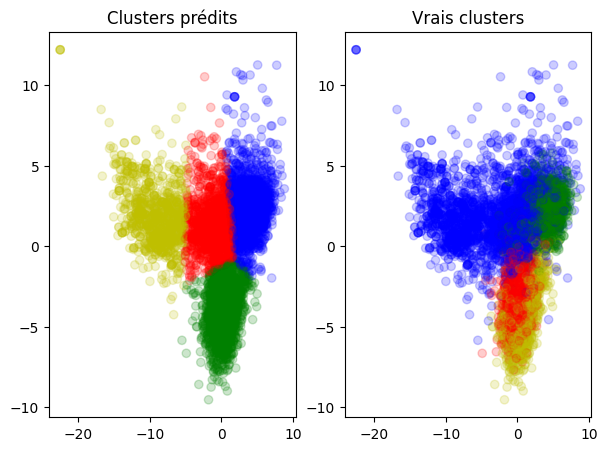

In [ ]:
# Récupération des objet R contenant les résultats
rkm_labels = np.array(robjects.r('rkm_result$cluster'))
rkm_result = np.array(robjects.r('rkm_result$obscoord'))

# Soustraction pour faire correspondre les valeurs issues de R à celles de python
rkm_labels = rkm_labels - 1

# Evaluation de la qualité du clustering
print_metrics(rkm_labels, y)

# Comparaison des clusters en 2D 
clust_viz_2D(rkm_result, rkm_labels)

Les clusters ne sont pas bien séparés. L'espace réduit de RKM n'est pas adapté.

## Deep KMeans

In [ ]:
# Approche simultanée avec Deep KMeans
dkm_result, dkm_result_labels = DKM(array_glove, n_clusters=4, n_components=2)

<ipython-input-65-b8ce86626ea5>:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input,


Starting autoencoder pretraining...


100%|██████████| 50/50 [02:57<00:00,  3.56s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [05:02<00:00, 15.12s/it]


NMI score:  0.4888743152555037
Accuracy:  0.16955602536997885
ARI:  0.30976340216016074


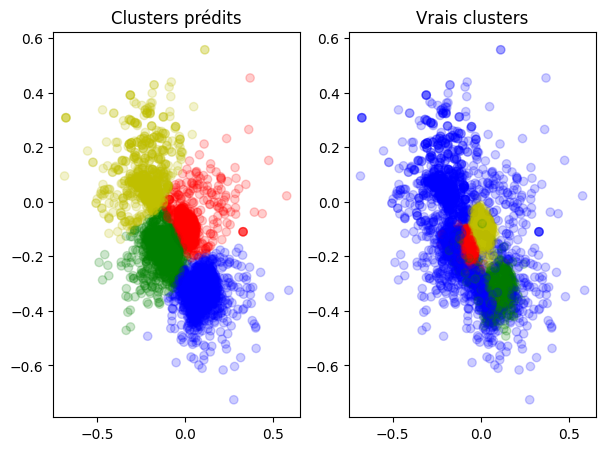

In [ ]:
# Evaluation de la qualité du clustering
print_metrics(dkm_result_labels, y)

# Comparaison des clusters en 2D 
clust_viz_2D(dkm_result, dkm_result_labels)

DKM fait encore moins bien. Il faudrait expérimenter avec d'autres hyperparamètres.

# Conclusion

In [ ]:
# Ajout des résultats des approches simultanées au tableau récapitulatif
tab_all = tab.reset_index()

new_rows = [{'index': 'RKM', 
             'NMI': normalized_mutual_info_score(rkm_labels, y),
             'Accuracy': accuracy_score(rkm_labels, y),
             'ARI': adjusted_rand_score(rkm_labels, y),
             'NMI-ARI mean': np.mean([normalized_mutual_info_score(rkm_labels, y),
                                      adjusted_rand_score(rkm_labels, y)])},
            {'index': 'DKM', 
             'NMI': normalized_mutual_info_score(dkm_result_labels, y),
             'Accuracy': accuracy_score(dkm_result_labels, y),
             'ARI': adjusted_rand_score(dkm_result_labels, y),
             'NMI-ARI mean': np.mean([normalized_mutual_info_score(dkm_result_labels, y),
                                      adjusted_rand_score(dkm_result_labels, y)])}]

tab_all = tab_all.append(new_rows, ignore_index=True).set_index('index')

# Affichage du tableau de synthèse des résultats
tab_all

<ipython-input-68-1b0d9a5b26f2>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_all = tab_all.append(new_rows, ignore_index=True).set_index('index')


NMI  Accuracy       ARI  NMI-ARI mean
index                                                               
Kmeans++                  0.507973  0.494433  0.379654      0.443814
Kmedoids                  0.304149  0.493446  0.219687      0.261918
Spherical Kmeans          0.325383  0.111346  0.162458      0.243920
CAH (simple)              0.000522  0.451163 -0.000354      0.000084
CAH (complet)             0.008785  0.444257 -0.006029      0.001378
CAH (moyen)               0.001558  0.450317 -0.001060      0.000249
CAH (Ward)                0.561938  0.009020  0.430419      0.496178
PCA + Kmeans++            0.493224  0.199859  0.325444      0.409334
PCA + Kmedoids            0.496361  0.010994  0.346544      0.421452
PCA + Spherical Kmeans    0.487663  0.101903  0.333809      0.410736
PCA + CAH (simple)        0.001041  0.450740 -0.000707      0.000167
PCA + CAH (complet)       0.230432  0.323890  0.091687      0.161060
PCA + CAH (moyen)         0.169692  0.211416 -0.036179      0.066756
PCA + CAH (Ward)          0.490014  0.432135  0.311748      0.400881
t-SNE + Kmeans++          0.513757  0.182523  0.400262      0.457010
t-SNE + Kmedoids          0.673189  0.209020  0.546552      0.609871
t-SNE + Spherical Kmeans  0.638837  0.025934  0.529129      0.583983
t-SNE + CAH (simple)      0.004115  0.448203 -0.002812      0.000651
t-SNE + CAH (complet)     0.474307  0.177449  0.348169      0.411238
t-SNE + CAH (moyen)       0.686342  0.378999  0.498402      0.592372
t-SNE + CAH (Ward)        0.490014  0.432135  0.311748      0.400881
UMAP + Kmeans++           0.688746  0.205779  0.524756      0.606751
UMAP + Kmedoids           0.691913  0.259619  0.534256      0.613084
UMAP + Spherical Kmeans   0.432234  0.336998  0.273975      0.353105
UMAP + CAH (simple)       0.445078  0.447780  0.241069      0.343073
UMAP + CAH (complet)      0.686253  0.428330  0.505156      0.595705
UMAP + CAH (moyen)        0.674789  0.470049  0.479762      0.577275
UMAP + CAH (Ward)         0.676561  0.444820  0.474314      0.575438
AE + Kmeans++             0.447581  0.096688  0.320316      0.383948
AE + Kmedoids             0.501573  0.654123  0.343907      0.422740
AE + Spherical Kmeans     0.424185  0.240874  0.267496      0.345841
AE + CAH (simple)         0.001041  0.450740 -0.000707      0.000167
AE + CAH (complet)        0.309236  0.435518  0.180862      0.245049
AE + CAH (moyen)          0.009863  0.441720 -0.007688      0.001088
AE + CAH (Ward)           0.481086  0.331501  0.321644      0.401365
RKM                       0.509726  0.143481  0.346575      0.428151
DKM                       0.488874  0.169556  0.309763      0.399319

In [ ]:
# Meilleure combinaison
tab_all[tab_all["NMI-ARI mean"]==tab_all["NMI-ARI mean"].max()]

NMI  Accuracy       ARI  NMI-ARI mean
index                                                      
UMAP + Kmedoids  0.691913  0.259619  0.534256      0.613084

Affichage du meilleur clustering

NMI score:  0.6919126932526527
Accuracy:  0.25961945031712474
ARI:  0.5342560194268579


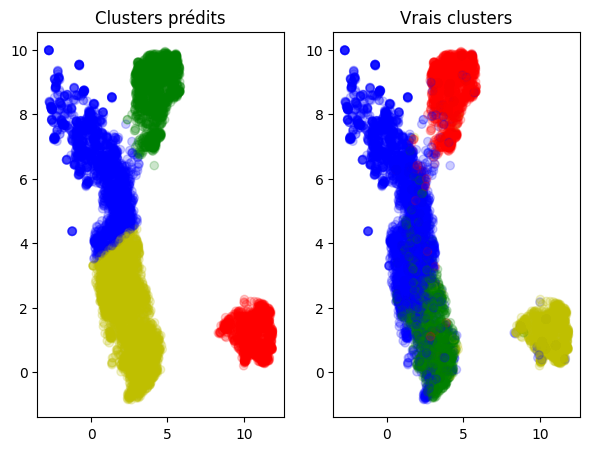

In [ ]:
# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_kmedoids.labels_)

Les clusters sont équivalents à ceux obtenus avec les embeddings Word2Vec.